## Matching DoG keypoints between original and scaled image for OpenCV and Kornia

* measuring the reprojection mean error and mse
* matching based on the position (original image) and reprojected position (scaled image)     
* matching a) based on mutual nearest neighbor b) with reprojection error < threshold (usually 2 pixels)
* optionally filtered with "size check" 
  * ratio = (kpt_size_scaled / scale) / kpt_size_original
  * 1 + abs(1 - ratio) < threshold (usually 1.1)
  * doesn't work for Kornia as the sizes are not consistent there 
* the exact scales (originally multiples of 0.1) are corrected so that the exactly preserve the scale ratio
* the ground truth homography and its inverse are

$H_{gt} = \begin{bmatrix} 
s & 0 & (s-1) / 2 \\
0 & s & (s-1) / 2 \\
0 & 0 & 1\\
\end{bmatrix}$

$H_{gt}^{-1} = \begin{bmatrix} 
1/s & 0 & (1-s) / 2s \\
0 & 1/s & (1-s) / 2s \\
0 & 0 & 1\\
\end{bmatrix}$

* measured on the first n images from the marketplace_dataset (scene ai_001_001) 
from the ml-hypersim dataset (https://github.com/apple/ml-hypersim)


In [1]:
import torch
import math
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

from geometry import mnn


def detect_kpts(img_np, detector, correct):

    kpts = detector.detect(img_np, mask=None)

    if len(kpts) == 0:
        return [], []

    kpt_f = torch.tensor([[kp.pt[0], kp.pt[1]] for kp in kpts])
    if correct:
        kpt_f -= 0.25
    scales = torch.tensor([kp.size for kp in kpts])

    return kpt_f, scales


def scale_pil(img, scale, show=False):
    real_scale = scale
    h, w = img.size
    integer_scale = True
    if integer_scale:
        gcd = math.gcd(w, h)

        real_scale_gcd = round(gcd * scale)
        real_scale = real_scale_gcd / gcd
        if real_scale == 0.0 or math.fabs(real_scale - scale) > 0.1:
            raise Exception("scale {} cannot be effectively realized for w, h = {}, {} in integer domain".format(scale, w, h))
    w_sc = round(w * real_scale)
    h_sc = round(h * real_scale)
    img_r = img.resize((h_sc, w_sc), resample=Image.Resampling.LANCZOS)
    if show:
        show_pil(img_r)

    return img_r, real_scale


def show_pil(img):
    npa = np.array(img)
    plt.figure()
    plt.imshow(npa)
    plt.show()


def get_pil_img(path, show=False):
    img = Image.open(path)
    if show:
        show_pil(img)
    return img


def get_img_tuple(path, scale, show=False):

    img = get_pil_img(path, show)
    img_r, real_scale = scale_pil(img, scale=scale, show=show)
    img = np.array(img)
    img_r = np.array(img_r)

    return img, img_r, real_scale


def write_results(experiment_name, means, mse):

    print()
    print(experiment_name)
    print()
    print("\t\tMean error")
    print("Scale\t\tx\t\ty")
    for i, mean in enumerate(means):
        print(f"{scales[i]}\t\t{mean[0]:.4f}\t\t{mean[1]:.4f}")
    print()
    print("Scale\t\tMse")
    for i, one_mse in enumerate(mse):
        print(f"{scales[i]}\t\t{one_mse:.4f}")


def plot_data(title, ylabel, data, labels, colors=["red", "blue"], miny=0.0):

    fig, ax = plt.subplots(1, figsize=(6, 4))
    plt.title(title)

    maxx = 0.0
    for i, d in enumerate(data):
        maxx = max(maxx, d.max().item())
        ax.plot(scales, d, linewidth=1.5, markersize=0.5, label=labels[i], color=colors[i])

    plt.ylim(miny, math.ceil(maxx / 0.05) * 0.05)
    plt.xlim(0.1, 0.9)

    location = 'best'
    plt.legend(shadow=True, framealpha=None, loc=location, fontsize="x-large")

    plt.xlabel("scale", fontsize="x-large")
    plt.ylabel(ylabel, fontsize="x-large")

    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()

    plt.show()


def scale_experiment(detector, nfiles, scales, scale_ratio_th, err_th):

    files = sorted([f"imgs/hypersim/{fn}" for fn in os.listdir("imgs/hypersim")])[:nfiles]
    means = torch.zeros((2, len(scales), 2))
    mse = torch.zeros((2, len(scales)))

    for i, o_scale in enumerate(tqdm(scales, leave=False)):
        for corrected in [0, 1]:
            errors = torch.zeros((0, 2))
            for i_f, file in enumerate(files):

                img_or, img_r_or, scale = get_img_tuple(file, o_scale)
                if i_f == 0 and corrected == 0:
                    print(f"scale:{o_scale} => {scale}, ({i + 1}/{len(scales)})")

                kpts, kpt_scales = detect_kpts(img_or, detector, corrected==1)
                kpts_r, kpt_scales_r = detect_kpts(img_r_or, detector, corrected==1)

                if len(kpts) == 0 or len(kpts_r) == 0:
                    continue

                kpts_reprojected = kpts_r / scale + (1 - scale) / (2 * scale)
                kpts, kpts_reprojected, mask, mask_reprojected = mnn(kpts, kpts_reprojected, err_th / scale)
                kpt_scales = kpt_scales[mask]
                kpt_scales_r = kpt_scales_r[mask_reprojected]

                diffs = (kpts_reprojected - kpts) * scale
                # now filter based on the scale ratio threshold (doesn't work for Kornia)
                if scale_ratio_th is not None:
                    kpts_r_scales_backprojected = kpt_scales_r / scale
                    scale_ratios = kpts_r_scales_backprojected / kpt_scales
                    mask_ratio_th = 1 + torch.abs(1 - scale_ratios) < scale_ratio_th
                    diffs = diffs[mask_ratio_th]

                if len(kpts) == 0:
                    continue
                errors = torch.vstack((errors, diffs))
            means[corrected, i] = errors.mean(axis=0)
            mse[corrected, i] = (torch.linalg.norm(errors, axis=1) ** 2).mean()

    return means, mse


  0%|          | 0/9 [00:00<?, ?it/s]

scale:0.1 => 0.1015625, (1/9)
scale:0.2 => 0.19921875, (2/9)
scale:0.3 => 0.30078125, (3/9)
scale:0.4 => 0.3984375, (4/9)
scale:0.5 => 0.5, (5/9)
scale:0.6 => 0.6015625, (6/9)
scale:0.7 => 0.69921875, (7/9)
scale:0.8 => 0.80078125, (8/9)
scale:0.9 => 0.8984375, (9/9)

OpenCV SIFT

		Mean error
Scale		x		y
0.1		0.2237		0.2307
0.2		0.2045		0.2005
0.3		0.1802		0.1746
0.4		0.1500		0.1524
0.5		0.1293		0.1280
0.6		0.1039		0.0995
0.7		0.0725		0.0743
0.8		0.0507		0.0493
0.9		0.0318		0.0278

Scale		Mse
0.1		0.1227
0.2		0.1124
0.3		0.1151
0.4		0.0974
0.5		0.0441
0.6		0.1098
0.7		0.1253
0.8		0.0727
0.9		0.1058

Corrected OpenCV SIFT

		Mean error
Scale		x		y
0.1		0.2237		0.2307
0.2		0.2045		0.2005
0.3		0.1802		0.1746
0.4		0.1500		0.1524
0.5		0.1293		0.1280
0.6		0.1039		0.0995
0.7		0.0725		0.0743
0.8		0.0507		0.0493
0.9		0.0318		0.0278

Scale		Mse
0.1		0.1227
0.2		0.1124
0.3		0.1151
0.4		0.0974
0.5		0.0441
0.6		0.1098
0.7		0.1253
0.8		0.0727
0.9		0.1058


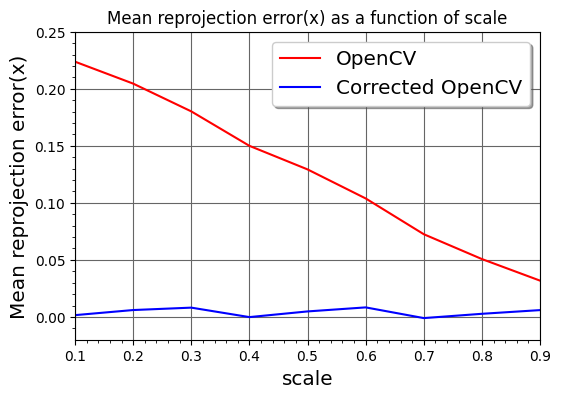

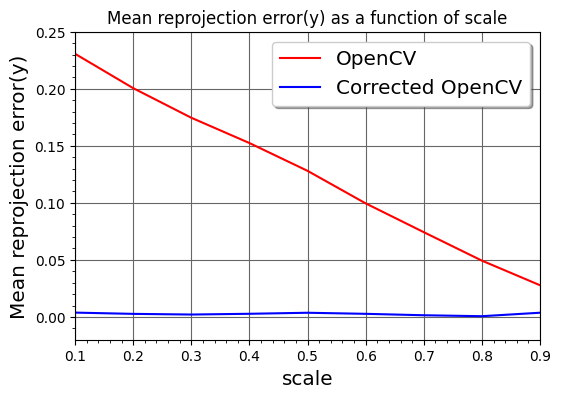

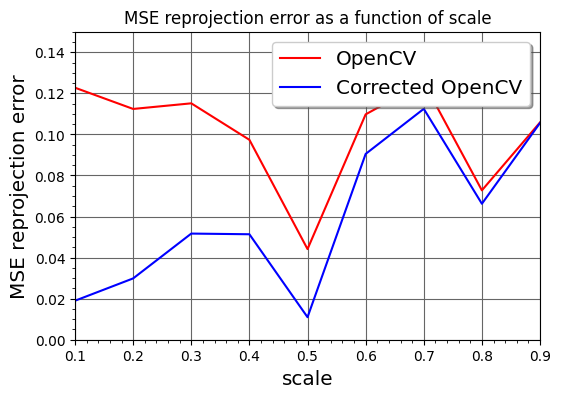

In [2]:
detector = cv.SIFT_create()

scales = [scale_int / 10 for scale_int in range(1, 10)]
means, mse = scale_experiment(detector, nfiles=10, scales=scales, scale_ratio_th=1.1, err_th=2.0)
write_results("OpenCV SIFT", means[0], mse[0])
write_results("Corrected OpenCV SIFT", means[0], mse[0])
plot_data("Mean reprojection error(x) as a function of scale", "Mean reprojection error(x)", [means[0, :, 0], means[1, :, 0]], ["OpenCV", "Corrected OpenCV"], miny=-0.02)
plot_data("Mean reprojection error(y) as a function of scale", "Mean reprojection error(y)", [means[0, :, 1], means[1, :, 1]], ["OpenCV", "Corrected OpenCV"], miny=-0.02)
plot_data("MSE reprojection error as a function of scale", "MSE reprojection error", [mse[0], mse[1]], ["OpenCV", "Corrected OpenCV"])


  0%|          | 0/9 [00:00<?, ?it/s]

scale:0.1 => 0.1015625, (1/9)
scale:0.2 => 0.19921875, (2/9)
scale:0.3 => 0.30078125, (3/9)
scale:0.4 => 0.3984375, (4/9)
scale:0.5 => 0.5, (5/9)
scale:0.6 => 0.6015625, (6/9)
scale:0.7 => 0.69921875, (7/9)
scale:0.8 => 0.80078125, (8/9)
scale:0.9 => 0.8984375, (9/9)

kornia SIFT

		Mean error
Scale		x		y
0.1		-0.0064		0.0082
0.2		0.0314		0.0399
0.3		0.0666		0.0734
0.4		0.0794		0.0772
0.5		0.1396		0.0993
0.6		0.0708		0.0747
0.7		0.0468		0.0710
0.8		0.0312		0.0604
0.9		0.0164		0.0185

Scale		Mse
0.1		0.1436
0.2		0.3805
0.3		0.5244
0.4		0.5002
0.5		0.4041
0.6		0.4675
0.7		0.4586
0.8		0.4246
0.9		0.4300

Corrected Kornia SIFT

		Mean error
Scale		x		y
0.1		-0.0064		0.0082
0.2		0.0314		0.0399
0.3		0.0666		0.0734
0.4		0.0794		0.0772
0.5		0.1396		0.0993
0.6		0.0708		0.0747
0.7		0.0468		0.0710
0.8		0.0312		0.0604
0.9		0.0164		0.0185

Scale		Mse
0.1		0.1436
0.2		0.3805
0.3		0.5244
0.4		0.5002
0.5		0.4041
0.6		0.4675
0.7		0.4586
0.8		0.4246
0.9		0.4300


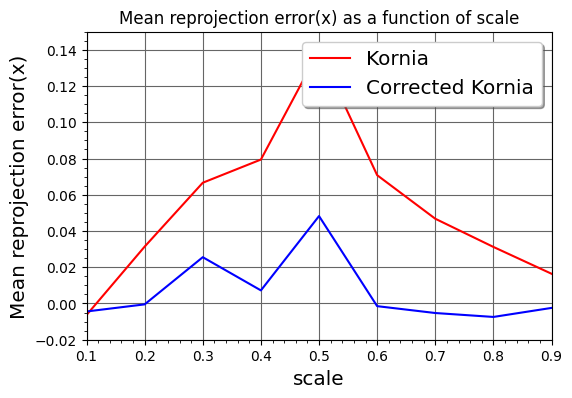

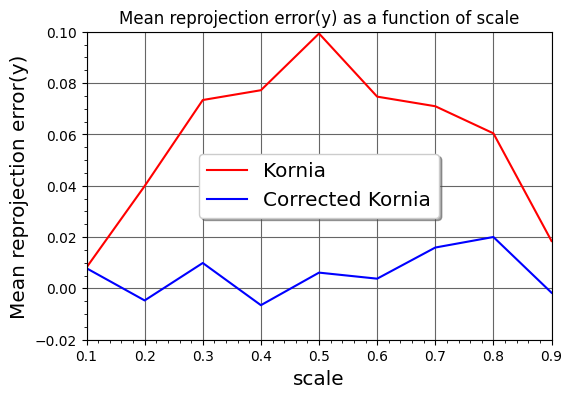

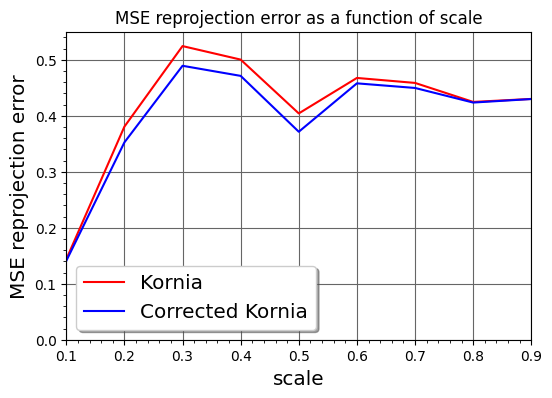

In [3]:
from kornia.feature.integrated import SIFTFeature
from kornia.utils import image_to_tensor
import torch


class NumpyKorniaSiftDescriptor:

    def __init__(self, device=torch.device("cpu")):
        self.device = device
        self.sf = SIFTFeature(device=device)

    @staticmethod
    def cv_kpt_from_laffs_responses(laffs, responses):
        kpts = []
        for i, response in enumerate(responses[0]):
            yx = laffs[0, i, :, 2]
            kp = cv.KeyPoint(yx[0].item(), yx[1].item(), response.item(), angle=0)
            kpts.append(kp)
        return kpts

    def detect(self, img, mask):
        assert mask is None, "not implemented with non-trivial mask"
        if len(img.shape) == 2:
            img = img[:, :, None]
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_t = (image_to_tensor(img, False).float() / 255.).to(device=self.device)
        laffs, responses, descs = self.sf(img_t, mask=None)
        kpts = self.cv_kpt_from_laffs_responses(laffs, responses)
        return kpts


detector = NumpyKorniaSiftDescriptor()

scales = [scale_int / 10 for scale_int in range(1, 10)]
means, mse = scale_experiment(detector, nfiles=2, scales=scales, scale_ratio_th=None, err_th=2.0)
write_results("kornia SIFT", means[0], mse[0])
write_results("Corrected Kornia SIFT", means[0], mse[0])
plot_data("Mean reprojection error(x) as a function of scale", "Mean reprojection error(x)", [means[0, :, 0], means[1, :, 0]], ["Kornia", "Corrected Kornia"], miny=-0.02)
plot_data("Mean reprojection error(y) as a function of scale", "Mean reprojection error(y)", [means[0, :, 1], means[1, :, 1]], ["Kornia", "Corrected Kornia"], miny=-0.02)
plot_data("MSE reprojection error as a function of scale", "MSE reprojection error", [mse[0], mse[1]], ["Kornia", "Corrected Kornia"])
